In [1]:
import numpy as np
import scipy.stats as sps
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Global Variables
WAD = 10**18
RAY = 10**27
RAD = 10**45
SPY = 31536000 # seconds per year
MAX = 2**255
SPH = 60*60

In [3]:
params = {
    'expected_lag': [10],
    'minimum_period': [SPH],
    'correction_wt': [0.5],
    'noise_wt': [0.001]
}

params

{'expected_lag': [10],
 'minimum_period': [3600],
 'correction_wt': [0.5],
 'noise_wt': [0.001]}

In [4]:
state = {
    'price': int(RAY), #in 1/RAY
    'target': int(RAY), #in 1/RAY
    'error': {'new':0, 'old':0}, #in 1/RAY
    'integral': 0,  #in seconds/RAY
    'Dt': 0, #seconds
    'timestamp': dt.datetime.now() #date
}

state

{'price': 1000000000000000000000000000,
 'target': 1000000000000000000000000000,
 'error': {'new': 0, 'old': 0},
 'integral': 0,
 'Dt': 0,
 'timestamp': datetime.datetime(2020, 8, 29, 19, 31, 13, 378959)}

In [5]:
def event(params, step, sL, s):

    error =s['price']-s['target']
    delta_time = sps.expon.rvs(loc = params['minimum_period'], scale = params['expected_lag'])

    return({'error':error, 'delta_time': delta_time})

def time_move(params, step, sL, s, _input):

    seconds = _input['delta_time']
    td = dt.timedelta(days=0, seconds=seconds)
    key = 'timestamp'
    value = s['timestamp']+td

    return(key, value)

def store_Dt(params, step, sL, s, _input):

    key = 'Dt'
    value = np.floor(_input['delta_time'])

    return(key, value)

def store_error(params, step, sL, s, _input):

    key = 'error'

    new_error = _input['error']
    old_error = s['error']['new']

    value = {'new':new_error, 'old':old_error}

    return(key, value)

def update_integral(params, step, sL, s, _input):
    """
    Given integral previous value I, and the last two errors [new_error, old_error] and time pased Dt
        A = Dt*(new_error+old_error)/2
        I = I + A  
    """

    new_error = s['error']['new']
    old_error = s['error']['old']

    e_bar = int((new_error+old_error)/2)

    Dt = s['Dt']

    area = e_bar*Dt

    value = s['integral']+area
    key = 'integral'

    return(key, value)

def martingale(params, step, sL, s):

    theta = params['correction_wt']
    noise = np.random.randn()*params['noise_wt']
    raw_price = float(s['price'])/RAY
    raw_target = float(s['target'])/RAY

    raw_price = theta*raw_target+(1-theta)*raw_price + noise
    
    return({'raw_price':raw_price})

def price_move(params, step, sL, s, _input):

    raw_price = _input['raw_price']
    price = int(raw_price*RAY)

    key = 'price'
    value = price

    return(key, value)

In [6]:
PSUBs = [
    {
        'policies': {
            'update_event': event
        },
        'variables': {
            'error': store_error,
            'timestamp':time_move,
            'Dt': store_Dt
        }
    },
    {
        'policies': {},
        'variables': {
            'integral': update_integral,
        }
    },
    {
        'policies': {
            'martingale': martingale        },
        'variables': {
            'price': price_move,
        }
    },
]

In [7]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim

sim_config = config_sim (
    {
        'T': range(100),
        'N': 1,
        'M': params
    }
)

In [8]:

exp = Experiment()

exp.append_configs(
    sim_configs=sim_config,
    initial_state=state,
    partial_state_update_blocks=PSUBs
)

from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.local_mode)
executor = Executor(exec_context, 2 * configs)
raw_result, tensor, _ = executor.execute()

df = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 4, 2, 6)
Execution Method: local_simulations
SimIDs   : [0, 0]
SubsetIDs: [0, 0]
Ns       : [0, 0]
ExpIDs   : [0, 0]
Execution Mode: parallelized
Total execution time: 0.16s


In [9]:
rdf = df[df.substep == 3].copy()

In [10]:
rdf.head()

,price,target,error,integral,Dt,timestamp,simulation,subset,run,substep,timestep
3,1000041003399954052507762688,1000000000000000000000000000,"{'new': 0, 'old': 0}",0.000000e+00,3617.0,2020-08-29 20:31:30.480449,0,0,1,3,1
6,999028648684363304438595584,1000000000000000000000000000,"{'new': 41003399954052507762688, 'old': 0}",7.491321e+25,3654.0,2020-08-29 21:32:24.518156,0,0,1,3,2
9,999545794045560036410785792,1000000000000000000000000000,"{'new': -971351315636695561404416, 'old': 4100...",-1.603900e+27,3609.0,2020-08-29 22:32:33.911315,0,0,1,3,3
12,998739394649918080783745024,1000000000000000000000000000,"{'new': -454205954439963589214208, 'old': -971...",-4.171328e+27,3602.0,2020-08-29 23:32:35.955850,0,0,1,3,4
15,998591031770155325419683840,1000000000000000000000000000,"{'new': -1260605350081919216254976, 'old': -45...",-7.269992e+27,3614.0,2020-08-30 00:32:50.234385,0,0,1,3,5


In [11]:
rdf['normed_integral'] = rdf.integral.apply(lambda x: x/(RAY*SPH))
rdf['normed_price'] = rdf.price.apply(lambda x: x/RAY)
rdf['normed_target'] = rdf.target.apply(lambda x: x/RAY)
rdf['normed_error']  = rdf.normed_price-rdf.normed_target

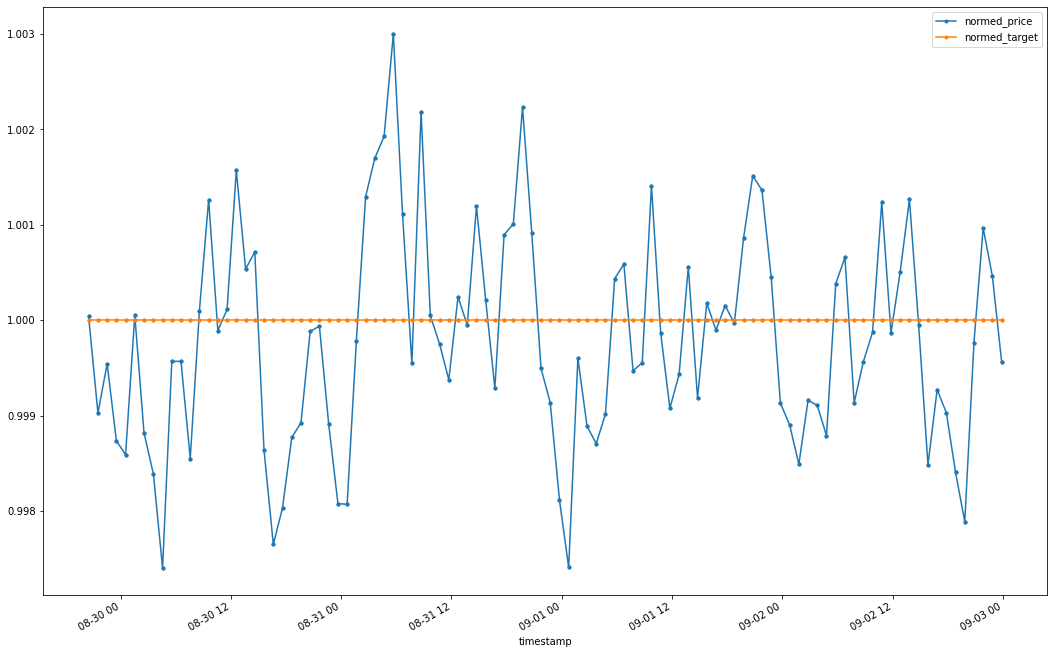

In [12]:
plt.figure(figsize=(18, 12))
rdf.plot(x='timestamp', y=['normed_price','normed_target'], marker='.', ax=plt.gca())

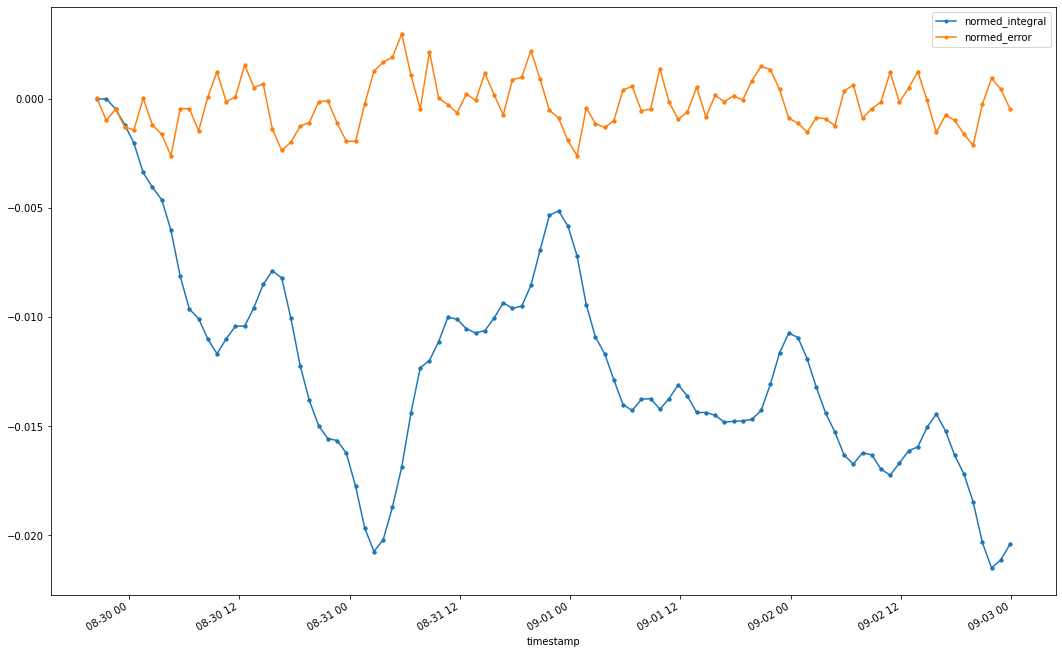

In [13]:
plt.figure(figsize=(18, 12))
rdf.plot(x='timestamp', y=['normed_integral', 'normed_error'], marker='.', ax=plt.gca())

In [14]:
rdf['new_error'] = rdf.error.apply(lambda x: float(x['new']/RAY))
rdf['old_error'] = rdf.error.apply(lambda x: float(x['old']/RAY))

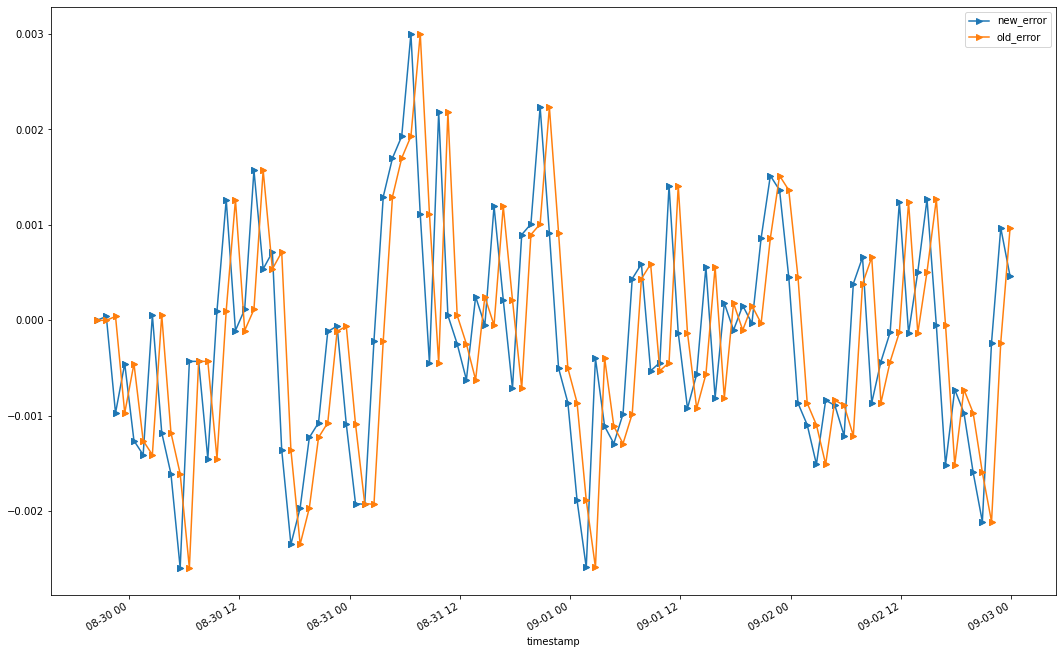

In [15]:
plt.figure(figsize=(18, 12))
rdf[['new_error','old_error','timestamp']].plot(x='timestamp', marker='>', ax=plt.gca())